<a href="https://colab.research.google.com/github/zusoomro/545FinalProject/blob/master/545_Final_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Introduction

In this project, I will be using a [dataset](https://www.kaggle.com/sobhanmoosavi/us-accidents/data) on 3 million accidents in the US that occured between Feb 2016 and Dec 2019. I am going to use information from the dataset to predict a given accident's impact on traffic. An example use case here is using the analysis and models to provide accurate traffic slowdown predictions for accidents based on public information about the accident. This would aid in conservatively estimating travel times for navigation applications for example. 

Some features which I am going to use in the model are:

- Local road features near the accident
- The weather conditions at the time of the accident
- A natural language description of the accident
- The [TMC code](https://wiki.openstreetmap.org/wiki/TMC/Event_Code_List) of the accident

Thanks for taking a look!

# Setup

In [59]:
# Loading in modules

import numpy as np
import pandas as pd
import matplotlib

import gc
import time
import warnings

import nltk
nltk.download('punkt')

import matplotlib.pyplot as plt
import seaborn as sns

import scipy
from sklearn.decomposition import IncrementalPCA
from sklearn import tree
from sklearn import ensemble
import sklearn

from google.colab import drive

pd.set_option('display.max_colwidth', None)  

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [60]:
# Mounting my Google Drive and loading the dataset from my local machine

drive.mount('/content/drive')

drive_data_path = (
  "/content/drive/My Drive/CIS 545/Final Project/US_Accidents_Dec19.csv")

with open(drive_data_path, 'r') as f:
  data = pd.read_csv(f)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data exploration

In [61]:
# Let's take a look at a sample of the data

data.head()

,ID,Source,TMC,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-1,MapQuest,201.0,3,2016-02-08 05:46:00,2016-02-08 11:00:00,39.865147,-84.058723,NaN,NaN,0.01,Right lane blocked due to accident on I-70 Eastbound at Exit 41 OH-235 State Route 4.,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2,MapQuest,201.0,2,2016-02-08 06:07:59,2016-02-08 06:37:59,39.928059,-82.831184,NaN,NaN,0.01,Accident on Brice Rd at Tussing Rd. Expect delays.,2584.0,Brice Rd,L,Reynoldsburg,Franklin,OH,43068-3402,US,US/Eastern,KCMH,2016-02-08 05:51:00,37.9,NaN,100.0,29.65,10.0,Calm,NaN,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Day
2,A-3,MapQuest,201.0,2,2016-02-08 06:49:27,2016-02-08 07:19:27,39.063148,-84.032608,NaN,NaN,0.01,Accident on OH-32 State Route 32 Westbound at Dela Palma Rd. Expect delays.,NaN,State Route 32,R,Williamsburg,Clermont,OH,45176,US,US/Eastern,KI69,2016-02-08 06:56:00,36.0,33.3,100.0,29.67,10.0,SW,3.5,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,True,False,Night,Night,Day,Day
3,A-4,MapQuest,201.0,3,2016-02-08 07:23:34,2016-02-08 07:53:34,39.747753,-84.205582,NaN,NaN,0.01,Accident on I-75 Southbound at Exits 52 52B US-35. Expect delays.,NaN,I-75 S,R,Dayton,Montgomery,OH,45417,US,US/Eastern,KDAY,2016-02-08 07:38:00,35.1,31.0,96.0,29.64,9.0,SW,4.6,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Day,Day,Day
4,A-5,MapQuest,201.0,2,2016-02-08 07:39:07,2016-02-08 08:09:07,39.627781,-84.188354,NaN,NaN,0.01,Accident on McEwen Rd at OH-725 Miamisburg Centerville Rd. Expect delays.,NaN,Miamisburg Centerville Rd,R,Dayton,Montgomery,OH,45459,US,US/Eastern,KMGY,2016-02-08 07:53:00,36.0,33.3,89.0,29.65,6.0,SW,3.5,NaN,Mostly Cloudy,False,False,False,False,False,False,False,False,False,False,False,True,False,Day,Day,Day,Day


In [62]:
# ... the distribution of severity labels ...

gb = data.groupby(['Severity']).count()
gb['ID']

Severity
1        968
2    1993410
3     887620
4      92337
Name: ID, dtype: int64

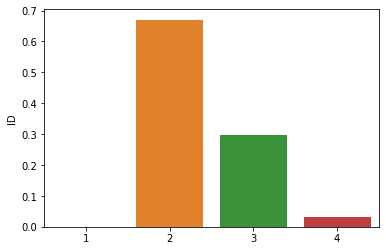

In [63]:
sns.barplot(x=gb.index.values, y=gb['ID'] / data.shape[0])

Note that our data is disproportionately labeled with over 60% of the having traffic severity 2. We will have to keep this in mind going forward. 

In [64]:
# ... the shape of the data ...

data.shape

(2974335, 49)

In [65]:
# ... the names of the columns in the data ...

data.columns

Index(['ID', 'Source', 'TMC', 'Severity', 'Start_Time', 'End_Time',
       'Start_Lat', 'Start_Lng', 'End_Lat', 'End_Lng', 'Distance(mi)',
       'Description', 'Number', 'Street', 'Side', 'City', 'County', 'State',
       'Zipcode', 'Country', 'Timezone', 'Airport_Code', 'Weather_Timestamp',
       'Temperature(F)', 'Wind_Chill(F)', 'Humidity(%)', 'Pressure(in)',
       'Visibility(mi)', 'Wind_Direction', 'Wind_Speed(mph)',
       'Precipitation(in)', 'Weather_Condition', 'Amenity', 'Bump', 'Crossing',
       'Give_Way', 'Junction', 'No_Exit', 'Railway', 'Roundabout', 'Station',
       'Stop', 'Traffic_Calming', 'Traffic_Signal', 'Turning_Loop',
       'Sunrise_Sunset', 'Civil_Twilight', 'Nautical_Twilight',
       'Astronomical_Twilight'],
      dtype='object')

In [66]:
# ... the distribution of the numerical data ...

data.describe()

,TMC,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,2.246264e+06,2.974335e+06,2.974335e+06,2.974335e+06,728071.000000,728071.000000,2.974335e+06,1.056730e+06,2.918272e+06,1.121712e+06,2.915162e+06,2.926193e+06,2.908644e+06,2.533495e+06,975977.000000
mean,2.078316e+02,2.360190e+00,3.649361e+01,-9.542625e+01,37.580871,-99.976032,2.855654e-01,5.837004e+03,6.235120e+01,5.132685e+01,6.540542e+01,2.983190e+01,9.150770e+00,8.298064e+00,0.020495
std,2.032959e+01,5.414733e-01,4.918849e+00,1.721881e+01,5.004757,18.416647,1.548392e+00,1.515928e+04,1.878855e+01,2.519127e+01,2.255676e+01,7.213808e-01,2.892114e+00,5.138546e+00,0.235770
min,2.000000e+02,1.000000e+00,2.455527e+01,-1.246238e+02,24.570110,-124.497829,0.000000e+00,0.000000e+00,-7.780000e+01,-6.590000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000
25%,2.010000e+02,2.000000e+00,3.355040e+01,-1.172920e+02,33.957554,-118.286610,0.000000e+00,8.370000e+02,5.000000e+01,3.200000e+01,4.900000e+01,2.982000e+01,1.000000e+01,4.600000e+00,0.000000
50%,2.010000e+02,2.000000e+00,3.584969e+01,-9.025083e+01,37.903670,-96.631690,0.000000e+00,2.717000e+03,6.440000e+01,5.400000e+01,6.700000e+01,2.998000e+01,1.000000e+01,7.000000e+00,0.000000
75%,2.010000e+02,3.000000e+00,4.037026e+01,-8.091891e+01,41.372630,-82.323850,1.000000e-02,7.000000e+03,7.600000e+01,7.300000e+01,8.400000e+01,3.011000e+01,1.000000e+01,1.040000e+01,0.000000
max,4.060000e+02,4.000000e+00,4.900220e+01,-6.711317e+01,49.075000,-67.109242,3.336300e+02,9.999997e+06,1.706000e+02,1.150000e+02,1.000000e+02,3.304000e+01,1.400000e+02,8.228000e+02,25.000000


In [67]:
# ... and the types of the data.

data.dtypes

ID                        object
Source                    object
TMC                      float64
Severity                   int64
Start_Time                object
End_Time                  object
Start_Lat                float64
Start_Lng                float64
End_Lat                  float64
End_Lng                  float64
Distance(mi)             float64
Description               object
Number                   float64
Street                    object
Side                      object
City                      object
County                    object
State                     object
Zipcode                   object
Country                   object
Timezone                  object
Airport_Code              object
Weather_Timestamp         object
Temperature(F)           float64
Wind_Chill(F)            float64
Humidity(%)              float64
Pressure(in)             float64
Visibility(mi)           float64
Wind_Direction            object
Wind_Speed(mph)          float64
Precipitat

Right off the bat, I'm going to be taking a look at the information that's relevant for my model. For example, a column like source is probably not going to have a significant impact on the traffic severity of a given accident. I'm going to look to take out columns which don't convey a lot of meaningful information and further process columns which do.

Next, I'll look at the initial correlation of the columns and determine if something like PCA would be helpful.

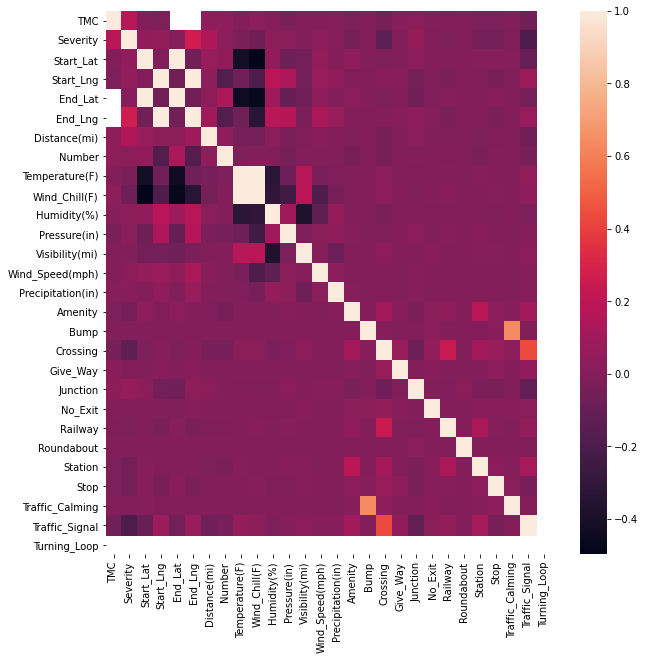

In [68]:
# and correlation between the current numerical columns.

corr = data.corr()
plt.figure(figsize=(10, 10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

Many of the strong correlations in this matrix have to do with the general weather conditions, so not things that I'm extemely interested in if I'm looking to predict severity. For example, temperature and wind chill seem to be correlated with visibility,and although that is interesting, it doesn't give me strong information about the severity of an accident based on the visibility at the scene. 

Furthermore, it looks like there aren't very many strong correlations among the initial numerical data. If this also the case after processing the text into tf-idf rankings, it might not be worth it to do PCA. This is because PCA will reduce the number of total features, but make them dense, which might actually increase the complexity of the dataset.

There does look to be some promising information though, as there are some columns which have a weak correlation with severity (such as distance).

Next, I'm going to take a deeper look at some columns that I'm interested in processing further.

## Description

In [69]:
data[['Severity', 'Description']].head(5)

,Severity,Description
0,3,Right lane blocked due to accident on I-70 Eastbound at Exit 41 OH-235 State Route 4.
1,2,Accident on Brice Rd at Tussing Rd. Expect delays.
2,2,Accident on OH-32 State Route 32 Westbound at Dela Palma Rd. Expect delays.
3,3,Accident on I-75 Southbound at Exits 52 52B US-35. Expect delays.
4,2,Accident on McEwen Rd at OH-725 Miamisburg Centerville Rd. Expect delays.


Looks like pretty formulaic descriptions of the accidents. If they include more information about the conditions for the more severe accidents, this could be vital in predicting the severity.

I'm now going to scan through a sample of each severity level and see if there are any trends that are immediately obvious.

In [70]:
data[data['Severity'] == 1][['Severity', 'Description']].head(5)

,Severity,Description
163,1,Accident on Westlawn Dr at Holly Dr.
374,1,Accident on North Ave at Old Byesville Rd.
960,1,Accident on Banta Rd at Brichetto Rd.
1390,1,Accident on Union Rd near Access Rd.
7851,1,Accident on CA-49 Southbound near CA-16.


In [71]:
data[data['Severity'] == 2][['Severity', 'Description']].head(5)

,Severity,Description
1,2,Accident on Brice Rd at Tussing Rd. Expect delays.
2,2,Accident on OH-32 State Route 32 Westbound at Dela Palma Rd. Expect delays.
4,2,Accident on McEwen Rd at OH-725 Miamisburg Centerville Rd. Expect delays.
6,2,Accident on Oakridge Dr at Woodward Ave. Expect delays.
8,2,Accident on Notre Dame Ave at Warner Ave. Expect delays.


In [72]:
data[data['Severity'] == 3][['Severity', 'Description']].head(5)

,Severity,Description
0,3,Right lane blocked due to accident on I-70 Eastbound at Exit 41 OH-235 State Route 4.
3,3,Accident on I-75 Southbound at Exits 52 52B US-35. Expect delays.
5,3,Accident on I-270 Outerbelt Northbound near Exit 29 OH-3 State St. Expect delays.
7,3,Accident on I-75 Southbound at Exit 54B Grand Ave. Expect delays.
9,3,Right hand shoulder blocked due to accident on I-270 Outerbelt Westbound at Exit 29 OH-3 State St.


In [73]:
data[data['Severity'] == 4][['Severity', 'Description']].head(5)

,Severity,Description
619,4,Entry ramp closed due to accident on OH-104 Frank Rd Northbound at I-71.
1197,4,Accident on I-280 Southbound at Exits 3A 3B Bird Ave.
1901,4,Accident on I-280 Southbound before Exits 43A 43B I-380. On the median.
4143,4,Right lane blocked and queueing traffic due to accident on I-680 Southbound before Exit 1A US-101. On the median.
4964,4,All lane blocked due to accident on I-880 Southbound at Marina Blvd.


So there actually looks to be a ton of information here! First, note that the severity 1 accidents don't seem to have descriptions which say to "expect delays". As the severity increases, it seems like the roads that they are occuring on are becoming state routes and eventually interstates. Additionally, the severity 4 accidents seem to have closed lanes or be on the median. If the model picks these words up from the td-idf representation, it might have a pretty good chance at determining the severity.

## TMC Codes

TMC Codes provide another additional description of the accident and might provide additional useful information. They are integers which can be decoded using a code list such as [this one](https://wiki.openstreetmap.org/wiki/TMC/Event_Code_List). I'm going to explore the TMC Codes in the data to determine if I want to one-hot-encode the codes for the model. If there is some sort of correlation with TMC code and the severity numerically, this might not be worth it. On the other hand, if there are few TMC codes which strongly correlate with severity, it definitely might make sense to decode that information.

In [74]:
# The correlation between severity and the numerical value of the TMC Code

data['TMC'].corr(data['Severity'])

0.17773884643289664

Looks like there's a weak correlation there. I'm going to one hot encode the values and take another look.

In [0]:
TMC_data = pd.concat([data['Severity'], pd.get_dummies(data['TMC'])], axis=1)
corr = TMC_data.corr()

And plotting it...

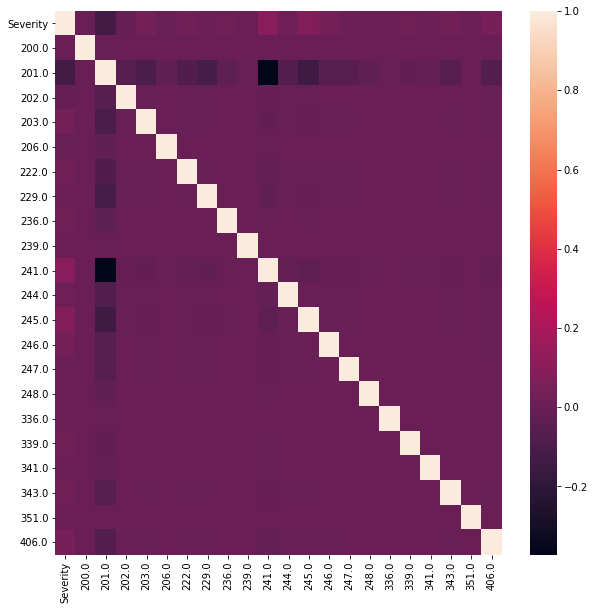

In [76]:
plt.figure(figsize=(10, 10))
sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns)

In [77]:
corr.shape

(22, 22)

So not too many correlations here (the row corresponding to Severity has mostly purple values). However, it looks like there are a few values which correlate with the severity, so I'm going to add this one hot encoding to the original dataset. From looking at the shape of the correlation matrix, it looks like there's actually only 21 distinct TMC values. This is definitely worth leaving in, especially if these one hot encodings can be put into a sparse format.

# Processing

In [78]:
data.shape

(2974335, 49)

We're starting out with a little under 3 million accident records and 49 data points about each. At the end of this section, we'll have narrowed that down to about 2 million accidents and expanded the feature set to ~650 features per accident.

## Removing invalid and irrelevant data

First, we're going to remove columns that aren't helpful to the task at hand: predicting severity. For example, we aren't going to be doing any sort of prediction using the location of the accident, so columns involving location can be dropped. Plus, we can get general information about the type of road the accident occurred on from the description ("...accident on I-95... "), which will be more helpful for the analysis.

As revealed by the EDA, we only have ~900 accidents with label 1. This poses a significant problem to the model as the "signal" from the other three labels are orders of magnitude larger than for label one. As a result, this class might be completely ignored in even well tuned models. While there are some approaches to alleviate class imbalances such as over- and under-sampling, the imbalance is so large there that it would be extremely difficult to appropriately represent the "1" label in the dataset. Consequently, we are going to remove the label from the dataset and continue analysis.

In [0]:
processed_data = data[data['Severity'] != 1]

In [0]:
processed_data = processed_data.drop(['Start_Lat', 'End_Lat', 'Start_Lng', 
                                      'End_Lng', 'Number', 'Street', 'City', 
                                      'County', 'State', 'Zipcode', 'Country', 
                                      'Timezone', 'Airport_Code'], axis=1)

I'm also going to drop many of the weather columns. In doing so I hope to reduce the number of rows overall that need to be dropped because of null values. I'm going to keep around Weather Condiiton, Visibility, and Temperature as general indicators of the weather at the accident. Finally, many of the day/night fields contain very similar data, so I'm going to keep one column and drop the rest.

In [0]:
processed_data = processed_data.drop(['Weather_Timestamp', 'Wind_Chill(F)', 
                                      'Humidity(%)', 'Pressure(in)', 
                                      'Wind_Direction', 'Wind_Speed(mph)',
                                      'Precipitation(in)', 'Civil_Twilight',
                                      'Nautical_Twilight',
                                      'Astronomical_Twilight'], axis=1)

Additionally, the ID column is not useful to us since pandas maintains its own separate id system.

In [0]:
processed_data = processed_data.drop(['ID'], axis=1)

Now taking a look at the nulls per column...

In [83]:
processed_data.isnull().sum(axis=0)

Source                    0
TMC                  728071
Severity                  0
Start_Time                0
End_Time                  0
Distance(mi)              0
Description               1
Side                      0
Temperature(F)        56047
Visibility(mi)        65670
Weather_Condition     65911
Amenity                   0
Bump                      0
Crossing                  0
Give_Way                  0
Junction                  0
No_Exit                   0
Railway                   0
Roundabout                0
Station                   0
Stop                      0
Traffic_Calming           0
Traffic_Signal            0
Turning_Loop              0
Sunrise_Sunset           93
dtype: int64

Although TMC has over 700k null values, it is a necessary part of our analysis. This was definitely a tough decision to make, but I'm going to drop rows which do not include it.

In [0]:
# Dropping all rows will null values

processed_data = processed_data.dropna()

## General data processing

In this section, I'm going to tackle:
- converting accident start and end times to an accident duration
- one hot encoding categorical data
- converting all bools to ints for scipy matrices

In [0]:
# Processing Start Time and End Time

df = pd.DataFrame()

df['Start_Time'] = pd.to_datetime(processed_data['Start_Time'])
df['End_Time'] = pd.to_datetime(processed_data['End_Time'])

df['Duration(s)'] = df['Start_Time'] - df['End_Time']
processed_data['Duration(s)'] = df['Duration(s)'].dt.seconds
processed_data = processed_data.drop(['Start_Time', 'End_Time'], axis=1)

In [86]:
processed_data['Duration(s)']

0          67560
1          84600
2          84600
3          84600
4          84600
           ...  
2246259    84623
2246260    84665
2246261    84701
2246262    84661
2246263    84600
Name: Duration(s), Length: 2187739, dtype: int64

In [0]:
# One hot encoding categorical data

processed_data = \
  pd.concat([processed_data.drop(['Source'], axis=1), 
             pd.get_dummies(processed_data['Source'], 
             sparse=True)], axis=1)

processed_data = \
  pd.concat([processed_data.drop(['Side'], axis=1), 
             pd.get_dummies(processed_data['Side'],
             sparse=True)], axis=1)

processed_data = \
  pd.concat([processed_data.drop(['Weather_Condition'], axis=1),
             pd.get_dummies(processed_data['Weather_Condition'], 
             sparse=True)], axis=1)
  
processed_data = \
  pd.concat([processed_data.drop(['Sunrise_Sunset'], axis=1),
             pd.get_dummies(processed_data['Sunrise_Sunset'], 
             sparse=True)], axis=1);

processed_data = \
  pd.concat([processed_data.drop(['TMC'], axis=1),
             pd.get_dummies(processed_data['TMC'], 
             sparse=True)], axis=1);

In [0]:
# Boolean features to ints

processed_data["Amenity"] = processed_data["Amenity"].astype(int)
processed_data["Bump"] = processed_data["Bump"].astype(int)
processed_data["Crossing"] = processed_data["Crossing"].astype(int)
processed_data["Give_Way"] = processed_data["Give_Way"].astype(int)
processed_data["Junction"] = processed_data["Junction"].astype(int)
processed_data["No_Exit"] = processed_data["No_Exit"].astype(int)
processed_data["Railway"] = processed_data["Railway"].astype(int)
processed_data["Roundabout"] = processed_data["Roundabout"].astype(int)
processed_data["Station"] = processed_data["Station"].astype(int)
processed_data["Stop"] = processed_data["Stop"].astype(int)
processed_data["Traffic_Calming"] = processed_data["Traffic_Calming"].astype(int)
processed_data["Traffic_Signal"] = processed_data["Traffic_Signal"].astype(int)
processed_data["Turning_Loop"] = processed_data["Turning_Loop"].astype(int)

## Description and TF-IDF

In this section, I'm going to be calculating TF-IDF scores for each document. TF-IDF is a way to assign weights to words in a record which correspond to their "uniqueness". TF-IDF looks at Term Frequency and Inverse Document Frequency - the higher the TF-IDF score is, the more important that word is to that document. More about TF-IDF can be read about [here](https://en.wikipedia.org/wiki/Tf%E2%80%93idf).

In order to prepare the description field for TF-IDF, I'm going to be processing it further. I'm going to remove convert all text to lowercase, remove stop words, stem the words, and remove all punctuation. I'll explain as I go along.

In [89]:
processed_data['Description'].head()

0    Right lane blocked due to accident on I-70 Eastbound at Exit 41 OH-235 State Route 4.
1                                       Accident on Brice Rd at Tussing Rd. Expect delays.
2              Accident on OH-32 State Route 32 Westbound at Dela Palma Rd. Expect delays.
3                        Accident on I-75 Southbound at Exits 52 52B US-35. Expect delays.
4                Accident on McEwen Rd at OH-725 Miamisburg Centerville Rd. Expect delays.
Name: Description, dtype: object

In [0]:
# Convert to lowercase

processed_data['Description'] = (processed_data['Description']
                                   .apply(lambda x: x.lower())) 

In [91]:
processed_data['Description'].head()

0    right lane blocked due to accident on i-70 eastbound at exit 41 oh-235 state route 4.
1                                       accident on brice rd at tussing rd. expect delays.
2              accident on oh-32 state route 32 westbound at dela palma rd. expect delays.
3                        accident on i-75 southbound at exits 52 52b us-35. expect delays.
4                accident on mcewen rd at oh-725 miamisburg centerville rd. expect delays.
Name: Description, dtype: object

In [92]:
# Remove punctuation

def remove_punctuation(string):
  # Dashes in Interstate names were causing them to be removed, so I'm replacing
  # them with spaces.
  string = string.replace('-', ' ')
  words = nltk.word_tokenize(string)
  new_words = [word for word in words if word.isalnum()]
  return " ".join(new_words)

processed_data['Description'] = (processed_data['Description']
                                   .apply(lambda x: remove_punctuation(x)))

processed_data['Description'].head()

0    right lane blocked due to accident on i 70 eastbound at exit 41 oh 235 state route 4
1                                        accident on brice rd at tussing rd expect delays
2               accident on oh 32 state route 32 westbound at dela palma rd expect delays
3                            accident on i 75 southbound at exits 52 52b us expect delays
4                 accident on mcewen rd at oh 725 miamisburg centerville rd expect delays
Name: Description, dtype: object

Stop words are commonly used words in a language. It is helpful for us to remove them here to reduce the amount of clutter in the TF-IDF representation. Without removing all stop words in the sentences, it is likely that the total number of features would be much higher (by virtue of having a greater number of distinct words). Without performing analysis on the structure of the sentences, stop words are likely to be useless to the model. Thus, we will remove them.

In [93]:
# Take out stop words

nltk.download('stopwords')
from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

def remove_stop_words(string):
  # We want to maintain interstate information, so I'm keeping the I
  words = nltk.word_tokenize(string)
  new_words = [word for word in words if (word not in stop or word is "i") ]
  return " ".join(new_words)

processed_data['Description'] = (processed_data['Description']
                                   .apply(lambda x: remove_stop_words(x)))

processed_data['Description'].head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


0    right lane blocked due accident i 70 eastbound exit 41 oh 235 state route 4
1                                     accident brice rd tussing rd expect delays
2            accident oh 32 state route 32 westbound dela palma rd expect delays
3                         accident i 75 southbound exits 52 52b us expect delays
4              accident mcewen rd oh 725 miamisburg centerville rd expect delays
Name: Description, dtype: object

To stem words means to remove the conjugation of tokens in your dataset. For example, to stem the word "running" means to convert it to "run". This is useful again because it reduces the number of total features in the TF-IDF representation while simplifying the sentences in the dataset. Stemming verbs allows the ML model to understand that "blocking" and "blocked" (stemmed to block) are likely to mean the same thing in two different descriptions.

In [94]:
# Stemming verbs

from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def stem(string):
  words = nltk.word_tokenize(string)
  new_words = [stemmer.stem(word) for word in words]
  return " ".join(new_words)

processed_data['Description'] = (processed_data['Description']
                                   .apply(lambda x: stem(x)))

processed_data['Description'].head()

0    right lane block due accid i 70 eastbound exit 41 oh 235 state rout 4
1                                      accid brice rd tuss rd expect delay
2           accid oh 32 state rout 32 westbound dela palma rd expect delay
3                        accid i 75 southbound exit 52 52b us expect delay
4             accid mcewen rd oh 725 miamisburg centervill rd expect delay
Name: Description, dtype: object

Now, on to calculating TF-IDF. I'm going to compute TF-IDF and vary the hyperparameters to result in a vocabulary that is appropriately sized. The hyperparameters to consider here are:
- min_df: the number (if an int is passed in) or percentage of documents a term must appear in to be placed in the vocabulary
- max_df: the number (if an int is passed in) or percentage of documents a term must not appear in to be placed in the vocabulary
  - This is to take out terms like "the", which might be so common that they do not give us any information on the document
- ngram_range: the range of words that are allowed in one term in the vocab
  - For example, "the quick" with an ngram_range of (1, 2) would return "the", "quick", "the quick"


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

tvec = TfidfVectorizer(min_df=.0025, max_df=.1, ngram_range=(1, 2))
tvec.fit(processed_data['Description'])
tvec_weights = tvec.transform(processed_data['Description'])

And just to visualize the most important terms in the first document:

In [96]:
def top_tfidf_feats(row, features, top_n=25):
    ''' Get top n tfidf values in row and return them with their corresponding feature names.'''
    topn_ids = np.argsort(row)[::-1][:top_n]
    top_feats = [(features[i], row[i]) for i in topn_ids]
    df = pd.DataFrame(top_feats)
    df.columns = ['feature', 'tfidf']
    return df

def top_feats_in_doc(Xtr, features, row_id, top_n=25):
  ''' Top tfidf features in specific document (matrix row) '''
  row = np.squeeze(Xtr[row_id].toarray())
  return top_tfidf_feats(row, features, top_n)

features = tvec.get_feature_names()

top_feats_in_doc(tvec_weights, features, 0, top_n=5)

,feature,tfidf
0,70 eastbound,0.439299
1,accid 70,0.402940
2,oh,0.394324
3,41,0.358399
4,state,0.353221


Finally, dropping the description column...

In [0]:
processed_data = processed_data.drop(['Description'], axis=1)

In [98]:
tvec_weights.shape

(2187739, 513)

In [99]:
processed_data.shape

(2187739, 162)

I will construct the final processed data so that the original features are to the left of the TF-IDF scores. After converting to a scipy sparse matrix, I'm going to lose the labels on the array, so moving forward I need to note to get the labels on the original data I can consult processed_data for rows 0 through 163, and features (the tvec_weights feature names) for anything higher than that.

Now, combining the TF-IDF horizontally with the original dataframe. The original dataframe will be to the left. Note that I am going to be using a scipy sparse matrix moving forward instead of a pandas DataFrame since it allows me to compress the data significantly and improve computation times.

Additionally, I'm going to remove the labels and put them in a separate DataFrame y. This separation of data and label is for the next section, modeling.

In [0]:
y = processed_data['Severity']

In [0]:
X = scipy.sparse.hstack(
    [scipy.sparse.csr_matrix(
      processed_data.drop(['Severity'], axis=1)
      .values.astype(np.float))
    , tvec_weights])

# Modeling

For the purposes of modeling, since there are many more accidents with label 2 than the other labels, we will look out for false negatives on the 3 and 4 labels. 

It is better for accidents to be labeled as having a higher traffic severity impact than a lower one - considering users looking at traffic data and deciding when to leave. It is better for them to leave earlier than they need to and arrive early than for them to leave when they think they need to and end up late. Thus, it is better for the model to err on the side of having a higher traffic prediction.

## Normalization and Train-Test Split

In this section, I'm going to scale the data and split it for modeling using a decision tree, random forest, and logistic regression.

In [0]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Standardizing the features based on unit variance
X = StandardScaler(with_mean=False).fit_transform(X)

# Splitting into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(\
  X, y, test_size=0.20, random_state=42)

## Decision Tree Classifier

First, I am going to implement a simple decision tree as a baseline for modeling. Sklearn's default decision tree has no max depth and splits on entropy, so it is likely that this tree will overfit to the training dataset.

In [0]:
# Fitting the model on the training set

dt = tree.DecisionTreeClassifier(criterion="entropy")
dt = dt.fit(X_train,y_train)

# Making a prediction on the test set

prediction = dt.predict(X_test)

In [104]:
accuracy = sklearn.metrics.accuracy_score(y_true = y_test, y_pred = prediction)
print("Accuracy: %.1f%%"% (accuracy*100))

Accuracy: 92.6%


This is a time where it is important to remember that our dataset has a class imbalance. The 92.6% accuracy measurement alone is not sufficient to determine model success, as the model can simply label the entire dataset as the majority class and get away with a naive-but-correct classficiation. Thus, we will further examine model metrics to get a better sense of the success of this algorithm.

Sklearn provides a few other model evaluation metrics - one that is pertinent here is balanced_accuracy, which is an average of the recall over the different classes. It is designed to be a stronger metric for class-imbalanced datasets than the standard accuracy measure.

In [105]:
accuracy = sklearn.metrics.balanced_accuracy_score(y_true = y_test, 
                                                   y_pred = prediction)
print("Balanced Accuracy: %.1f%%"% (accuracy*100))

Balanced Accuracy: 69.8%


As you can see, the balanced accuracy is a bit less impressive. This is a baseline that we will be trying to improve on. Let's dive in a little deeper to the class specifics here.

In [106]:
classification_report = sklearn.metrics.classification_report(y_true = y_test, 
                                                              y_pred = prediction)
print(classification_report)

              precision    recall  f1-score   support

           2       0.95      0.94      0.95    287185
           3       0.89      0.90      0.89    149388
           4       0.32      0.26      0.28       975

    accuracy                           0.93    437548
   macro avg       0.72      0.70      0.71    437548
weighted avg       0.93      0.93      0.93    437548



As you can see, the recall for class 4 is significantly lower than the other two classes, which is probably a result of the class imbalance being biased toward classes 2 and 3. To tie these metrics back to the orignial purpose of the analysis, this model would under-classify 0.84 of the most traffic-severe class of accidents. This performance would be unacceptable if the model were used as part of a system to provide conservative travel estimates as the few accidents which have tremendous traffic impact are being missed.

Thus, this will be the baseline recall for class 4 that we will look to increase.

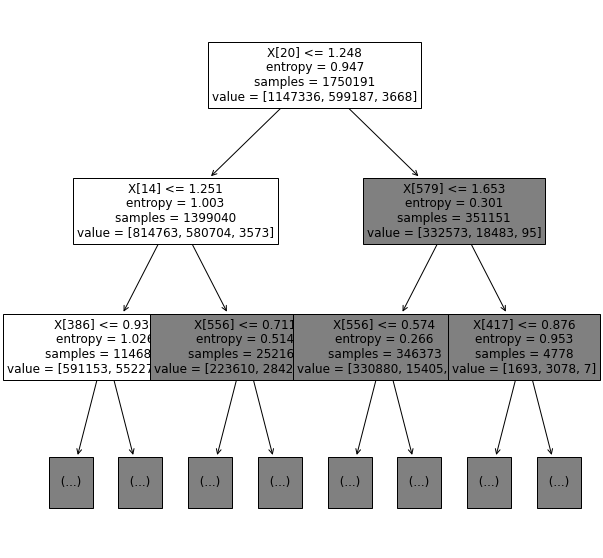

In [108]:
plt.figure(figsize=(10, 10))
sklearn.tree.plot_tree(dt, max_depth=2, fontsize=12)
plt.show()

It looks like there is significant entropy associated with splitting feature 20, which indicates that it is important in deciding the class label of the accident. This diagram shows the top of the decision tree, and the features that were split on for each node.

## Logistic Regression

Next, I'm going to implement a logistic regression. Here, I added the class_weight='balanced' parameter. This parameter is one way to account for imbalanced classes in datasets. Essentially, it assigns greater weights to the records from under-represented classes to make the minority classes have the same total weight as the larger classes. This should significantly improve our balanced accuracy metric.

In [109]:
# Fitting the model on the training set

lr = sklearn.linear_model.LogisticRegression(class_weight='balanced')
lr = lr.fit(X_train,y_train)

# Making a prediction on the test set

prediction = lr.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [110]:
accuracy = sklearn.metrics.accuracy_score(y_test, prediction)
print("Accuracy: %.1f%%"% (accuracy*100))

Accuracy: 91.4%


In [111]:
accuracy = sklearn.metrics.balanced_accuracy_score(y_test, prediction)
print("Balanced Accuracy: %.1f%%"% (accuracy*100))

Balanced Accuracy: 87.3%


In [112]:
classification_report = sklearn.metrics.classification_report(y_test, prediction)
print(classification_report)

              precision    recall  f1-score   support

           2       0.97      0.94      0.95    287185
           3       0.89      0.87      0.88    149388
           4       0.05      0.81      0.10       975

    accuracy                           0.91    437548
   macro avg       0.64      0.87      0.64    437548
weighted avg       0.94      0.91      0.93    437548



While the logistic regression with class balance has a slightly lower total accuracy, it has a much higher balanced accuracy than our baseline. Additionally, note that the recall for class 4 is now at 0.81, a significant improvement from the baseline. Since it looks like the recall for class 3 went down, it looks like the model might be correctly classifying accidents at the cost of misclassifying class 3 accidents as class 4. This is also evident by the extremely low precision score for class 4.

Despite the low precision, this model is a big improvement over our baseline. Here it is not important that our precision for class 4 is so low, since we would rather over-classify accident traffic impact than under-classify it in the use case of generating conservative travel time estimates.

## Random Forest

And now, a random forest with the class_weight balanced flag. The hope here is that by introducing a greater number of estimators, there will be a few which specialize to deciding between class 3 and class 4 accidents, improving the precision and recall of both classes.

In [0]:
# Fitting the model on the training set

rf = sklearn.ensemble.RandomForestClassifier(n_estimators=50, max_depth=10, 
                                             class_weight='balanced')
rf = rf.fit(X_train,y_train)

# Making a prediction on the test set

prediction = rf.predict(X_test)

In [114]:
accuracy = sklearn.metrics.accuracy_score(y_test, prediction)
print("Accuracy: %.1f%%"% (accuracy*100))

Accuracy: 85.4%


In [115]:
accuracy = sklearn.metrics.balanced_accuracy_score(y_test, prediction)
print("Balanced Accuracy: %.1f%%"% (accuracy*100))

Balanced Accuracy: 85.3%


In [116]:
classification_report = sklearn.metrics.classification_report(y_test, prediction)
print(classification_report)

              precision    recall  f1-score   support

           2       0.95      0.87      0.90    287185
           3       0.78      0.83      0.81    149388
           4       0.05      0.86      0.10       975

    accuracy                           0.85    437548
   macro avg       0.59      0.85      0.60    437548
weighted avg       0.89      0.85      0.87    437548



Looks like precision took a bit of a hit across the board, but recall for class 4 is up slightly. The balanced accuracy and accuracy are also a bit lower than the logistic regression as well, indicating that it might be a better model for this specific dataset.

# Conclusion

## Difficulties

A lot of the difficulty about this project definitely had to do with the size of the dataset, which began at ~3 million records. Sklearn's PCA outputs in a dense format, which made the data very hard to deal with afterwards. As a result of having to use almost all components to represent 0.9 explained variance and dense-output problem, I decided to forego PCA in this analysis and stick with the sparse scipy matrix format. This definitely made modeling more feasible in Colab. 

Nevertheless, the size of the dataset posed another problem when it came to modeling. I was unable to get meaningful results from a GridSeachCV (iterating over hyperparams to select optimal combinations) as training a model for every combination of hyperparameters pushed the limits of both Colab and my patience. As a result, I adopted more of a "guess and check" approach, iterating through parameters until I found ones that worked for my models. 

## Moving forward

If I had to do this analysis again, I would definitely consider using Spark and EMR. Although there is a bit more overhead with distributed computing, I think that being able to properly search for hyperparameters and use more complex models would definitely open more doors for analysis with this dataset. It seemed that TF-IDF for this dataset was appropriate because most of the descriptions seemed to be similar in format and thus the words themselves were good indicators of the content of the descriptions, but I would love the opportunity to perform more in-depth analysis on longer and more complex descriptions.